In [1]:
%%capture
!pip install wfdb

In [2]:
# Import 3rd party libraries
import os
import sys
import wfdb
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pylab as plt

# Configure Notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set database name
db_name = 'db2'
DATA_DIR = '/content/'
# Set raw data path
raw_path = os.path.join(DATA_DIR, db_name, 'raw')

# Download data set
wfdb.dl_database('afdb', raw_path)

# Get list of recordings
recording_ids = [file.split('.')[0] for file in os.listdir(raw_path) if '.dat' in file]

# Print list of recordings
print(recording_ids)

# Labels 
label_dict = {'AFIB': 'atrial fibrillation', 'AFL': 'atrial flutter', 'J': 'AV junctional rhythm'}

# Get sample frequency (Hz)
record = wfdb.rdrecord(os.path.join(raw_path, recording_ids[0]))
fs = record.__dict__['fs']


Generating record list for: 00735
Generating record list for: 03665
Generating record list for: 04015
Generating record list for: 04043
Generating record list for: 04048
Generating record list for: 04126
Generating record list for: 04746
Generating record list for: 04908
Generating record list for: 04936
Generating record list for: 05091
Generating record list for: 05121
Generating record list for: 05261
Generating record list for: 06426
Generating record list for: 06453
Generating record list for: 06995
Generating record list for: 07162
Generating record list for: 07859
Generating record list for: 07879
Generating record list for: 07910
Generating record list for: 08215
Generating record list for: 08219
Generating record list for: 08378
Generating record list for: 08405
Generating record list for: 08434
Generating record list for: 08455
Generating list of all files for: 00735
Generating list of all files for: 03665
Generating list of all files for: 04015
Generating list of all files f

In [4]:
# Empty dictionary for arrhythmia sections
sections = list()

# Loop through recordings
for recording_id in recording_ids:
    
    # Import recording
    record = wfdb.rdrecord(os.path.join(raw_path, recording_id))
    
    # Import annotations
    annotation = wfdb.rdann(os.path.join(raw_path, recording_id), 'atr')
    
    # Get waveform data
    data = record.__dict__['p_signal']
    
    # labels
    labels = [label[1:] for label in annotation.__dict__['aux_note']]
    
    # Samples
    sample = annotation.__dict__['sample']

    # Loop through labels
    for idx, label in enumerate(labels):
        
        if any(label in val for val in list(label_dict.keys())):

            if idx != len(labels) - 1:
                sections.append({'label': label, 'waveform': 1, 'record': recording_id, 
                                 'db': 'afdb', 'data': data[sample[idx]:sample[idx + 1], 0]})
                sections.append({'label': label, 'waveform': 2, 'record': recording_id,
                                 'db': 'afdb', 'data': data[sample[idx]:sample[idx + 1], 1]})
                
            elif idx == len(labels) - 1:
                sections.append({'label': label, 'waveform': 1, 'record': recording_id,
                                 'db': 'afdb', 'data': data[sample[idx]:, 0]})
                sections.append({'label': label, 'waveform': 2, 'record': recording_id,
                                 'db': 'afdb', 'data': data[sample[idx]:, 1]})

In [5]:
# Empty dictionary for arrhythmia samples
samples = list()

# Set sample length in seconds
sample_length = 60 

# Get sample length in sample points
sample_length_sp = sample_length * fs

# Loop through sections
for section in sections:
    
    # Set index
    idx = 0
    
    # Get number of samples in section
    num_samples = int(np.ceil(len(section['data']) / sample_length_sp))
    
    # Loop through samples
    for sample_id in range(num_samples):
        
        # Get sample
        if sample_id != num_samples - 1:
            samples.append({'label': section['label'], 'waveform': section['waveform'], 'record': section['record'],
                            'sample': sample_id, 'db': section['db'], 'data': section['data'][idx:idx + sample_length_sp]})
            idx += sample_length_sp
            
        elif sample_id == num_samples - 1:
            samples.append({'label': section['label'], 'waveform': section['waveform'], 'record': section['record'],
                            'sample': sample_id, 'db': section['db'], 'data': section['data'][idx:]})

In [6]:
# Set resample frequency (Hz)
fs_rs = 300

# Get time array
time = np.arange(sample_length_sp) * 1 / fs

# Loop through samples
for idx, sample in enumerate(samples):
    
    # Get time array
    time = np.arange(len(sample['data'])) * 1 / fs

    # Generate new resampling time array
    times_rs = np.arange(0, time[-1], 1 / fs_rs)

    # Setup interpolation function
    interp_func = interpolate.interp1d(x=time, y=sample['data'], kind='linear')

    # Interpolate contiguous segment
    values_rs = interp_func(times_rs)
    
    # Save resampled waveform
    samples[idx]['data'] = values_rs

In [8]:
# Set processed data path
processed_path = os.path.join(DATA_DIR, db_name, 'processed')

# Create empty DataFrame
labels = pd.DataFrame(data=[], columns=['db', 'record', 'label', 'sample', 'signal_id', 'train_label', 'file_name'])

# Loop through samples
for idx, sample in enumerate(samples):

    # Set file name
    file_name = '{}_{}_{}.npy'.format(sample['db'], sample['record'], idx)
    
    # Get labels
    labels = labels.append(pd.Series({'db': sample['db'], 'record': sample['record'], 'label': sample['label'], 
                                      'sample': sample['sample'], 'signal_id': sample['waveform'], 
                                      'train_label': 'A' if sample['label'] == 'AFIB' else 'O', 
                                      'file_name': file_name}), ignore_index=True)
    
    # Save waveform as .npy
    np.save(os.path.join(processed_path, file_name), sample['data'])

In [9]:
# Save labels
labels.to_csv(os.path.join('labels.csv'), index=False)

In [10]:
labels = pd.read_csv("labels.csv")

In [11]:
labels = pd.DataFrame(labels)

In [12]:
labels['train_label'].value_counts()

A    11532
O      242
Name: train_label, dtype: int64

In [13]:
train_label = labels['train_label']
file_name = labels['file_name']
alldata  = pd.concat([file_name,train_label],axis=1)
alldata = pd.DataFrame(alldata)

In [18]:
AFLJ = alldata[alldata['train_label'] == "O"]
AFIB = alldata[alldata['train_label'] == "A"]

In [19]:
AFLJ

file_name train_label
186      afdb_06995_186.npy           O
187      afdb_06995_187.npy           O
190      afdb_06995_190.npy           O
191      afdb_06995_191.npy           O
654      afdb_04908_654.npy           O
...                     ...         ...
11765  afdb_05121_11765.npy           O
11770  afdb_05121_11770.npy           O
11771  afdb_05121_11771.npy           O
11772  afdb_05121_11772.npy           O
11773  afdb_05121_11773.npy           O

[242 rows x 2 columns]

In [20]:
AFLJ_l = pd.DataFrame(AFLJ['train_label'])
AFLJ_l.reset_index(drop=True, inplace=True)
AFLJ_l

train_label
0             O
1             O
2             O
3             O
4             O
..          ...
237           O
238           O
239           O
240           O
241           O

[242 rows x 1 columns]

In [16]:
%%capture
!pip install matplotlib==3.1.3

In [23]:
import numpy as np
AF = np.load('/content/db2/processed/afdb_04015_712.npy')

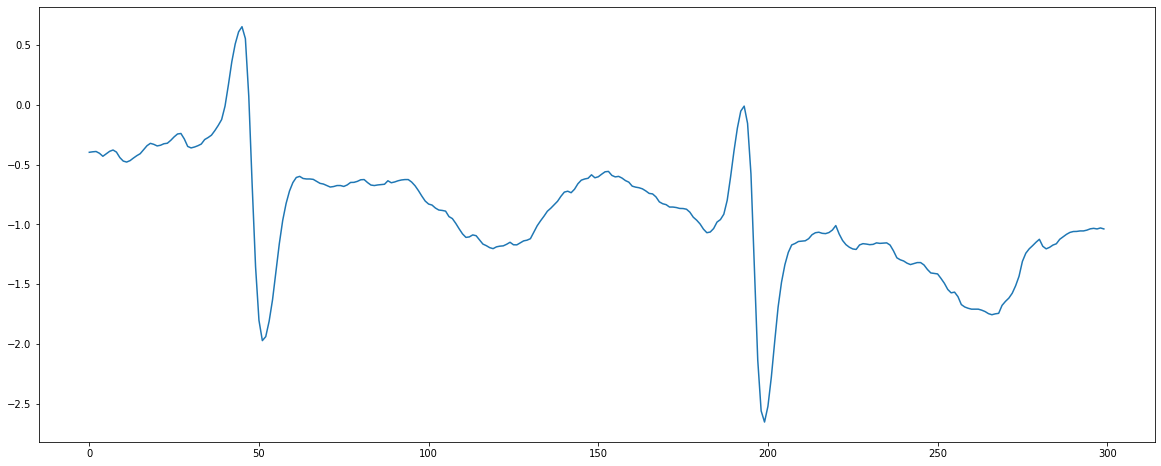

In [24]:
plt.figure(figsize=(20,8))
plt.plot(AF[200:500])

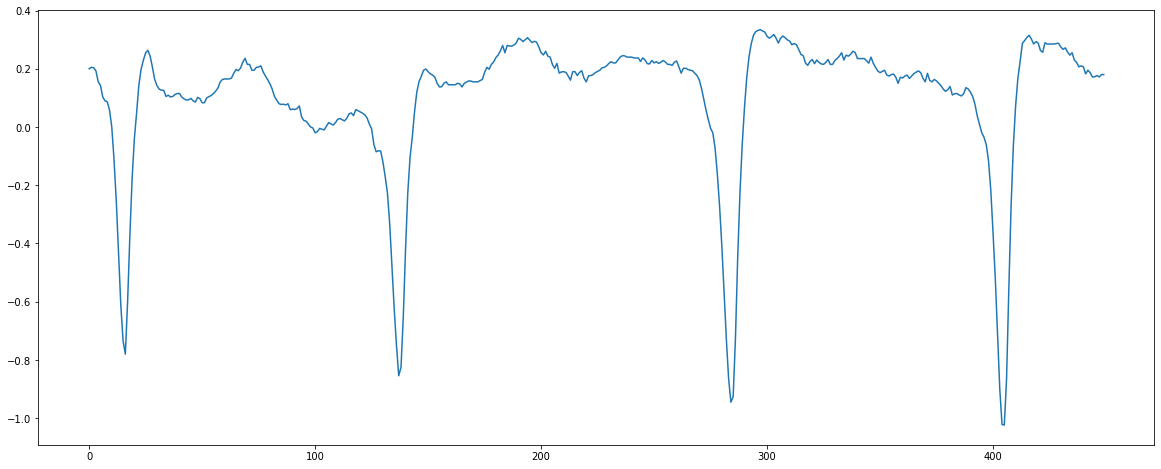

In [35]:
import numpy as np
AF = np.load('/content/db2/processed/afdb_04043_10518.npy')
plt.figure(figsize=(20,8))
plt.plot(AF[50:500])

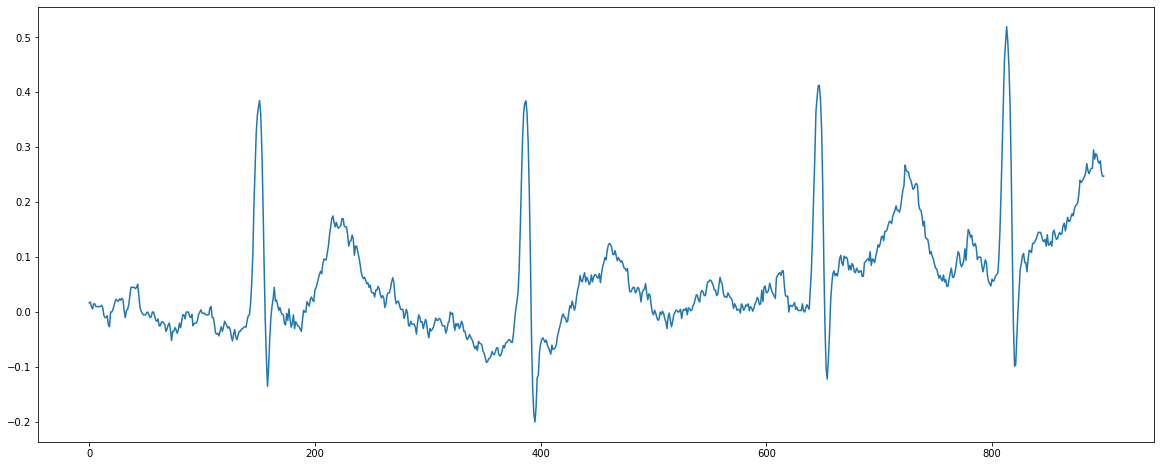

In [43]:
import numpy as np
AF = np.load('/content/db2/processed/afdb_04746_6373.npy')
plt.figure(figsize=(20,8))
plt.plot(AF[100:1000])

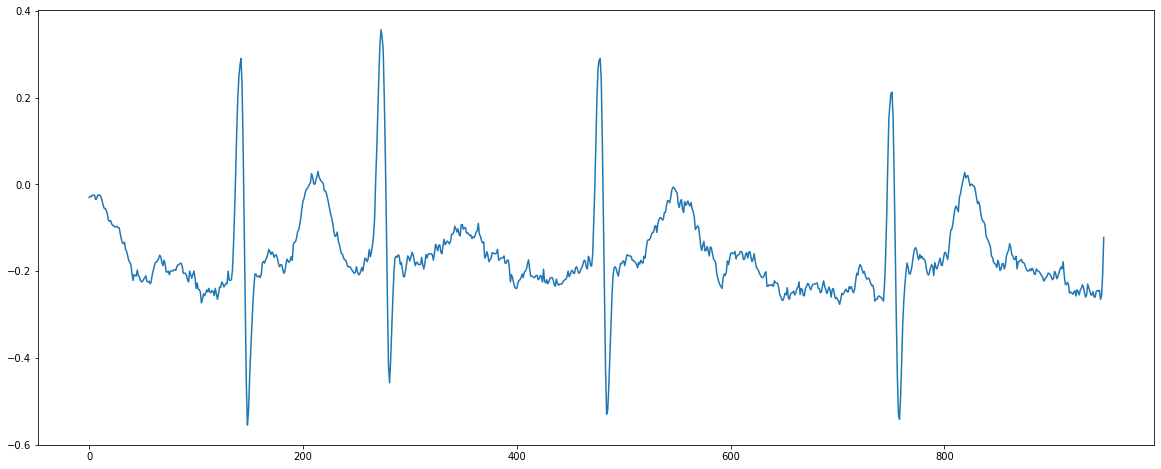

In [47]:
AFL = np.load('/content/db2/processed/afdb_04746_6459.npy')
plt.figure(figsize=(20,8))
plt.plot(AFL[50:1000])

In [48]:
AFIB = AFIB[:242]
dataset = pd.concat([AFIB , AFLJ])

In [49]:
dataset

file_name train_label
0          afdb_06995_0.npy           A
1          afdb_06995_1.npy           A
2          afdb_06995_2.npy           A
3          afdb_06995_3.npy           A
4          afdb_06995_4.npy           A
...                     ...         ...
11765  afdb_05121_11765.npy           O
11770  afdb_05121_11770.npy           O
11771  afdb_05121_11771.npy           O
11772  afdb_05121_11772.npy           O
11773  afdb_05121_11773.npy           O

[484 rows x 2 columns]

In [50]:
files = dataset['file_name'].values
AFIB = AFIB['file_name'].values
AFLJ = AFLJ['file_name'].values

In [51]:
AFIB_list = []
for i in AFIB:
  npy = np.load("/content/db2/processed/"+i)
  AFIB_list.append(npy)

In [52]:
data_AFIB = pd.DataFrame(AFIB_list)

In [53]:
data_AFIB = pd.concat([data_AFIB,dataset[:242]['train_label']],axis=1)

In [54]:
data_AFIB

0         1         2       3         4         5      6         7  \
0   -0.310 -0.335000 -0.320000 -0.2975 -0.248333 -0.145000  0.005  0.238333   
1    0.020  0.020000  0.040000  0.0550  0.063333  0.070833  0.075  0.066667   
2   -0.300 -0.304167 -0.308333 -0.3150 -0.313333 -0.303333 -0.320 -0.295000   
3   -0.265 -0.260833 -0.243333 -0.2425 -0.248333 -0.242500 -0.230 -0.246667   
4   -0.275 -0.270833 -0.273333 -0.2675 -0.266667 -0.277500 -0.265 -0.269167   
..     ...       ...       ...     ...       ...       ...    ...       ...   
241 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
242    NaN       NaN       NaN     NaN       NaN       NaN    NaN       NaN   
243    NaN       NaN       NaN     NaN       NaN       NaN    NaN       NaN   
244    NaN       NaN       NaN     NaN       NaN       NaN    NaN       NaN   
245    NaN       NaN       NaN     NaN       NaN       NaN    NaN       NaN   

            8       9  ...     17990   17991     17992     17993  17994  \
0    0.475000  0.6700  ... -0.135000 -0.1275 -0.115000 -0.100000 -0.075   
1    0.045000  0.0350  ... -0.361667 -0.3700 -0.365000 -0.352500 -0.340   
2   -0.286667 -0.2875  ... -0.236667 -0.2475 -0.256667 -0.269167 -0.265   
3   -0.226667 -0.2175  ... -0.316667 -0.3050 -0.291667 -0.287500 -0.300   
4   -0.276667 -0.2825  ... -0.508333 -0.7500 -0.836667 -0.818333 -0.710   
..        ...     ...  ...       ...     ...       ...       ...    ...   
241 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
242       NaN     NaN  ...       NaN     NaN       NaN       NaN    NaN   
243       NaN     NaN  ...       NaN     NaN       NaN       NaN    NaN   
244       NaN     NaN  ...       NaN     NaN       NaN       NaN    NaN   
245       NaN     NaN  ...       NaN     NaN       NaN       NaN    NaN   

        17995     17996         17997     17998  train_label  
0   -0.045833 -0.016667  8.881784e-15  0.006667            A  
1   -0.323333 -0.303333 -2.975000e-01 -0.298333            A  
2   -0.244167 -0.246667 -2.550000e-01 -0.261667            A  
3   -0.291667 -0.280000 -2.725000e-01 -0.275000            A  
4   -0.555833 -0.438333 -3.550000e-01 -0.298333            A  
..        ...       ...           ...       ...          ...  
241 -0.121667 -0.116667 -1.000000e-01 -0.061667            A  
242       NaN       NaN           NaN       NaN            A  
243       NaN       NaN           NaN       NaN            A  
244       NaN       NaN           NaN       NaN            A  
245       NaN       NaN           NaN       NaN            A  

[246 rows x 18000 columns]

In [55]:
AFLJ_list = []
for j in AFLJ:
  npy = np.load("/content/db2/processed/"+i)
  AFLJ_list.append(npy)

In [56]:
data_AFLJ = pd.DataFrame(AFLJ_list)

In [57]:
data_AFLJ

0      1         2      3         4         5      6         7      \
0    -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
1    -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
2    -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
3    -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
4    -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
..     ...    ...       ...    ...       ...       ...    ...       ...   
237  -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
238  -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
239  -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
240  -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   
241  -0.33 -0.355 -0.366667  -0.36 -0.348333 -0.344167  -0.34 -0.335833   

        8      9      ...     17989     17990  17991     17992     17993  \
0   -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
1   -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
2   -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
3   -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
4   -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
..        ...    ...  ...       ...       ...    ...       ...       ...   
237 -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
238 -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
239 -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
240 -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   
241 -0.331667  -0.34  ... -0.194167 -0.181667  -0.17 -0.161667 -0.150833   

     17994     17995     17996  17997     17998  
0    -0.13 -0.121667 -0.116667   -0.1 -0.061667  
1    -0.13 -0.121667 -0.116667   -0.1 -0.061667  
2    -0.13 -0.121667 -0.116667   -0.1 -0.061667  
3    -0.13 -0.121667 -0.116667   -0.1 -0.061667  
4    -0.13 -0.121667 -0.116667   -0.1 -0.061667  
..     ...       ...       ...    ...       ...  
237  -0.13 -0.121667 -0.116667   -0.1 -0.061667  
238  -0.13 -0.121667 -0.116667   -0.1 -0.061667  
239  -0.13 -0.121667 -0.116667   -0.1 -0.061667  
240  -0.13 -0.121667 -0.116667   -0.1 -0.061667  
241  -0.13 -0.121667 -0.116667   -0.1 -0.061667  

[242 rows x 17999 columns]

In [58]:
data_AFLJ_all = pd.concat([data_AFLJ , AFLJ_l],axis=1)

In [59]:
data_AFLJ_all

0      1         2     3         4         5     6         7  \
0   -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
1   -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
2   -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
3   -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
4   -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
..    ...    ...       ...   ...       ...       ...   ...       ...   
237 -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
238 -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
239 -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
240 -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   
241 -0.33 -0.355 -0.366667 -0.36 -0.348333 -0.344167 -0.34 -0.335833   

            8     9  ...     17990  17991     17992     17993  17994  \
0   -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
1   -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
2   -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
3   -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
4   -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
..        ...   ...  ...       ...    ...       ...       ...    ...   
237 -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
238 -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
239 -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
240 -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   
241 -0.331667 -0.34  ... -0.181667  -0.17 -0.161667 -0.150833  -0.13   

        17995     17996  17997     17998  train_label  
0   -0.121667 -0.116667   -0.1 -0.061667            O  
1   -0.121667 -0.116667   -0.1 -0.061667            O  
2   -0.121667 -0.116667   -0.1 -0.061667            O  
3   -0.121667 -0.116667   -0.1 -0.061667            O  
4   -0.121667 -0.116667   -0.1 -0.061667            O  
..        ...       ...    ...       ...          ...  
237 -0.121667 -0.116667   -0.1 -0.061667            O  
238 -0.121667 -0.116667   -0.1 -0.061667            O  
239 -0.121667 -0.116667   -0.1 -0.061667            O  
240 -0.121667 -0.116667   -0.1 -0.061667            O  
241 -0.121667 -0.116667   -0.1 -0.061667            O  

[242 rows x 18000 columns]

In [60]:
data  = pd.concat([data_AFIB,data_AFLJ_all],axis=0.)

In [61]:
data

0         1         2       3         4         5      6         7  \
0   -0.310 -0.335000 -0.320000 -0.2975 -0.248333 -0.145000  0.005  0.238333   
1    0.020  0.020000  0.040000  0.0550  0.063333  0.070833  0.075  0.066667   
2   -0.300 -0.304167 -0.308333 -0.3150 -0.313333 -0.303333 -0.320 -0.295000   
3   -0.265 -0.260833 -0.243333 -0.2425 -0.248333 -0.242500 -0.230 -0.246667   
4   -0.275 -0.270833 -0.273333 -0.2675 -0.266667 -0.277500 -0.265 -0.269167   
..     ...       ...       ...     ...       ...       ...    ...       ...   
237 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
238 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
239 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
240 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
241 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   

            8       9  ...     17990   17991     17992     17993  17994  \
0    0.475000  0.6700  ... -0.135000 -0.1275 -0.115000 -0.100000 -0.075   
1    0.045000  0.0350  ... -0.361667 -0.3700 -0.365000 -0.352500 -0.340   
2   -0.286667 -0.2875  ... -0.236667 -0.2475 -0.256667 -0.269167 -0.265   
3   -0.226667 -0.2175  ... -0.316667 -0.3050 -0.291667 -0.287500 -0.300   
4   -0.276667 -0.2825  ... -0.508333 -0.7500 -0.836667 -0.818333 -0.710   
..        ...     ...  ...       ...     ...       ...       ...    ...   
237 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
238 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
239 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
240 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
241 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   

        17995     17996         17997     17998  train_label  
0   -0.045833 -0.016667  8.881784e-15  0.006667            A  
1   -0.323333 -0.303333 -2.975000e-01 -0.298333            A  
2   -0.244167 -0.246667 -2.550000e-01 -0.261667            A  
3   -0.291667 -0.280000 -2.725000e-01 -0.275000            A  
4   -0.555833 -0.438333 -3.550000e-01 -0.298333            A  
..        ...       ...           ...       ...          ...  
237 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
238 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
239 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
240 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
241 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  

[488 rows x 18000 columns]

In [62]:
data.isna().sum()

0               4
1               4
2               4
3               4
4               4
               ..
17995          14
17996          14
17997          14
17998          14
train_label     4
Length: 18000, dtype: int64

In [63]:
mask=data.isnull().any(axis=1)
num_of_rows_with_nan=mask.sum()
num_of_total_rows=len(data)
print(num_of_rows_with_nan/ num_of_total_rows) 

0.028688524590163935


In [64]:
data_clean = data[~mask]
data_clean.shape

(474, 18000)

In [65]:
training_dataset = data_clean
training_dataset.shape

(474, 18000)

In [66]:
training_dataset

0         1         2       3         4         5      6         7  \
0   -0.310 -0.335000 -0.320000 -0.2975 -0.248333 -0.145000  0.005  0.238333   
1    0.020  0.020000  0.040000  0.0550  0.063333  0.070833  0.075  0.066667   
2   -0.300 -0.304167 -0.308333 -0.3150 -0.313333 -0.303333 -0.320 -0.295000   
3   -0.265 -0.260833 -0.243333 -0.2425 -0.248333 -0.242500 -0.230 -0.246667   
4   -0.275 -0.270833 -0.273333 -0.2675 -0.266667 -0.277500 -0.265 -0.269167   
..     ...       ...       ...     ...       ...       ...    ...       ...   
237 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
238 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
239 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
240 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   
241 -0.330 -0.355000 -0.366667 -0.3600 -0.348333 -0.344167 -0.340 -0.335833   

            8       9  ...     17990   17991     17992     17993  17994  \
0    0.475000  0.6700  ... -0.135000 -0.1275 -0.115000 -0.100000 -0.075   
1    0.045000  0.0350  ... -0.361667 -0.3700 -0.365000 -0.352500 -0.340   
2   -0.286667 -0.2875  ... -0.236667 -0.2475 -0.256667 -0.269167 -0.265   
3   -0.226667 -0.2175  ... -0.316667 -0.3050 -0.291667 -0.287500 -0.300   
4   -0.276667 -0.2825  ... -0.508333 -0.7500 -0.836667 -0.818333 -0.710   
..        ...     ...  ...       ...     ...       ...       ...    ...   
237 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
238 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
239 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
240 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   
241 -0.331667 -0.3400  ... -0.181667 -0.1700 -0.161667 -0.150833 -0.130   

        17995     17996         17997     17998  train_label  
0   -0.045833 -0.016667  8.881784e-15  0.006667            A  
1   -0.323333 -0.303333 -2.975000e-01 -0.298333            A  
2   -0.244167 -0.246667 -2.550000e-01 -0.261667            A  
3   -0.291667 -0.280000 -2.725000e-01 -0.275000            A  
4   -0.555833 -0.438333 -3.550000e-01 -0.298333            A  
..        ...       ...           ...       ...          ...  
237 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
238 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
239 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
240 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  
241 -0.121667 -0.116667 -1.000000e-01 -0.061667            O  

[474 rows x 18000 columns]

In [67]:
input = training_dataset.drop(['train_label'],axis=1)
output = training_dataset['train_label']

In [68]:
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [69]:
# splitting 33% for testing
x_train , x, y_train , y = train_test_split(input , output , test_size = 0.35 , random_state = 42)
# splitting the other part to trainset and validation set
x_test , x_val , y_test , y_val = train_test_split(x , y , test_size = 0.5 , random_state = 42)

In [70]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(308, 17999)
(83, 17999)
(83, 17999)


In [71]:
model = DecisionTreeClassifier(random_state=2)

# Train Decision Tree Classifer
model = model.fit(x_train,y_train)

In [72]:
y_pred_train = model.predict(x_train)
y_pred_val = model.predict(x_val)
y_pred_test = model.predict(x_test)

print('Training accuracy =', accuracy_score(y_train, y_pred_train))
print('Validation accuracy =', accuracy_score(y_val, y_pred_val))
print('test accuracy =', accuracy_score(y_test, y_pred_test))

Training accuracy = 0.9967532467532467
Validation accuracy = 0.9759036144578314
test accuracy = 0.9879518072289156


In [73]:
SVMmodel = SVC(C =  0.64,kernel='rbf', random_state=2)
SVMmodel.fit(x_train , y_train)
y_pred_train_svm = SVMmodel.predict(x_train)
y_pred_val_svm = SVMmodel.predict(x_val)
y_pred_test_svm = SVMmodel.predict(x_test)

print('Training accuracy =', accuracy_score(y_train, y_pred_train_svm))
print('Validation accuracy =', accuracy_score(y_val, y_pred_val_svm))
print('test accuracy =', accuracy_score(y_test, y_pred_test_svm))

Training accuracy = 0.9967532467532467
Validation accuracy = 1.0
test accuracy = 1.0


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [98]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = LinearRegression()

#use k-fold CV to evaluate model
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
mean(absolute(scores))

nan

In [99]:
cv = KFold(n_splits=5, random_state=1, shuffle=True) 

#build multiple linear regression model
model = LinearRegression()

#use LOOCV to evaluate model
scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

In [100]:
# Fitting Kfold to the Training set 
from sklearn.model_selection import KFold
KFold(n_splits=2, random_state=None, shuffle=False)
classifier.fit(x_train, y_train) 

# Predicting the Test set results
y_pred_trainn = classifier.predict(x_train)
y_pred_vall = classifier.predict(x_val)
y_pred_testt = classifier.predict(x_test)

print('Training accuracy =', accuracy_score(y_train, y_pred_trainn))
print('Validation accuracy =', accuracy_score(y_val, y_pred_vall))
print('test accuracy =', accuracy_score(y_test, y_pred_testt))

Training accuracy = 0.9967532467532467
Validation accuracy = 1.0
test accuracy = 1.0


In [101]:
test = np.load('/content/db2/processed/afdb_04746_6831.npy')
test = pd.DataFrame(test).T

In [102]:
test

0         1         2      3         4         5      6         7      \
0 -0.055 -0.075833 -0.063333  -0.06 -0.066667 -0.069167 -0.065 -0.048333   

   8       9      ...     17989     17990   17991     17992  17993  17994  \
0 -0.045 -0.0475  ... -0.314167 -0.311667 -0.3125 -0.311667   -0.3 -0.275   

      17995     17996  17997     17998  
0 -0.254167 -0.233333  -0.24 -0.258333  

[1 rows x 17999 columns]

In [103]:
test_svc = SVMmodel.predict(test)

In [104]:
test_svc

array(['A'], dtype=object)

In [109]:

import pickle
 
# Save the trained model as a pickle string.
saved_model = pickle.dumps(SVMmodel)
 
# Load the pickled model
SVMmodel = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
SVMmodel.predict(x_test)

array(['O', 'A', 'A', 'A', 'O', 'O', 'A', 'O', 'A', 'O', 'O', 'A', 'A',
       'A', 'A', 'O', 'O', 'O', 'O', 'O', 'A', 'A', 'O', 'O', 'O', 'A',
       'O', 'O', 'A', 'O', 'O', 'O', 'O', 'A', 'A', 'A', 'A', 'A', 'O',
       'A', 'A', 'O', 'A', 'A', 'A', 'O', 'A', 'A', 'O', 'O', 'A', 'O',
       'A', 'O', 'A', 'O', 'O', 'A', 'A', 'A', 'A', 'O', 'O', 'A', 'O',
       'O', 'A', 'O', 'A', 'A', 'O', 'A', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O'], dtype=object)